# Assignment 1 CAP 5516, Chest X-Ray classification

## Problem statement: Assume ResNet-18 is used as the network backbone, please complete the following two sub-tasks.

### Task 1.1
Train the model (e.g., ResNet-18) from scratch (i.e., random initialization of the model parameters) using the training X-ray images.

### Task 1.2
Leverage the pre-trained ResNet-18 (the same CNN used in Task 1.1) model on the ImageNet and fine tune the model on the target X-ray images (training set).

### Note
By using the techniques learned from class (e.g., data augmentation, model regularization, etc.), the goal is to achieve the best testing accuracy you can for Task 1.1 and Task 1.2. More training tricks or good practices can be found in [2].

In [1]:
import glob
import matplotlib.pyplot as plt
import cv2

## Explore data

In [2]:
!ls data/chest_xray/

test  train  val


In [38]:
train_fnames = glob.glob("data/chest_xray/train/*/*")
len(train_fnames)

5216

In [39]:
val_fnames = glob.glob("data/chest_xray/val/*/*")
len(val_fnames)

16

The size of the validation set is very small; we should redistribute the samples between the training and validation set so that more samples are used for validation. This is done in dataset.py

In [40]:
test_fnames = glob.glob("data/chest_xray/test/*/*")
len(test_fnames)

624

In [41]:
f"Number of samples: {len(train_fnames) + len(val_fnames) + len(test_fnames)}"

'Number of samples: 5856'

In [42]:
train_normal = [f for f in train_fnames if 'NORMAL' in f]
n_normal = len(train_normal)
n_normal

1341

In [43]:
train_pneumonia = [f for f in train_fnames if 'NORMAL' not in f]
n_pneumonia = len(train_pneumonia)
assert len(train_fnames) - n_normal == n_pneumonia
n_pneumonia

3875

### Bar chart showing count of normal and pneumonia samples in the training set

<BarContainer object of 2 artists>

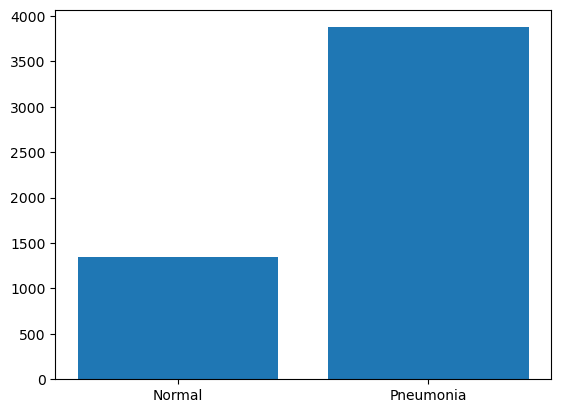

In [44]:
plt.bar(['Normal', 'Pneumonia'], [n_normal, n_pneumonia])

Can see that there is a large class imbalance, many more pneumonia than healthy images, need to do data augmentation or some sampling to fix this ratio

### Data visualization

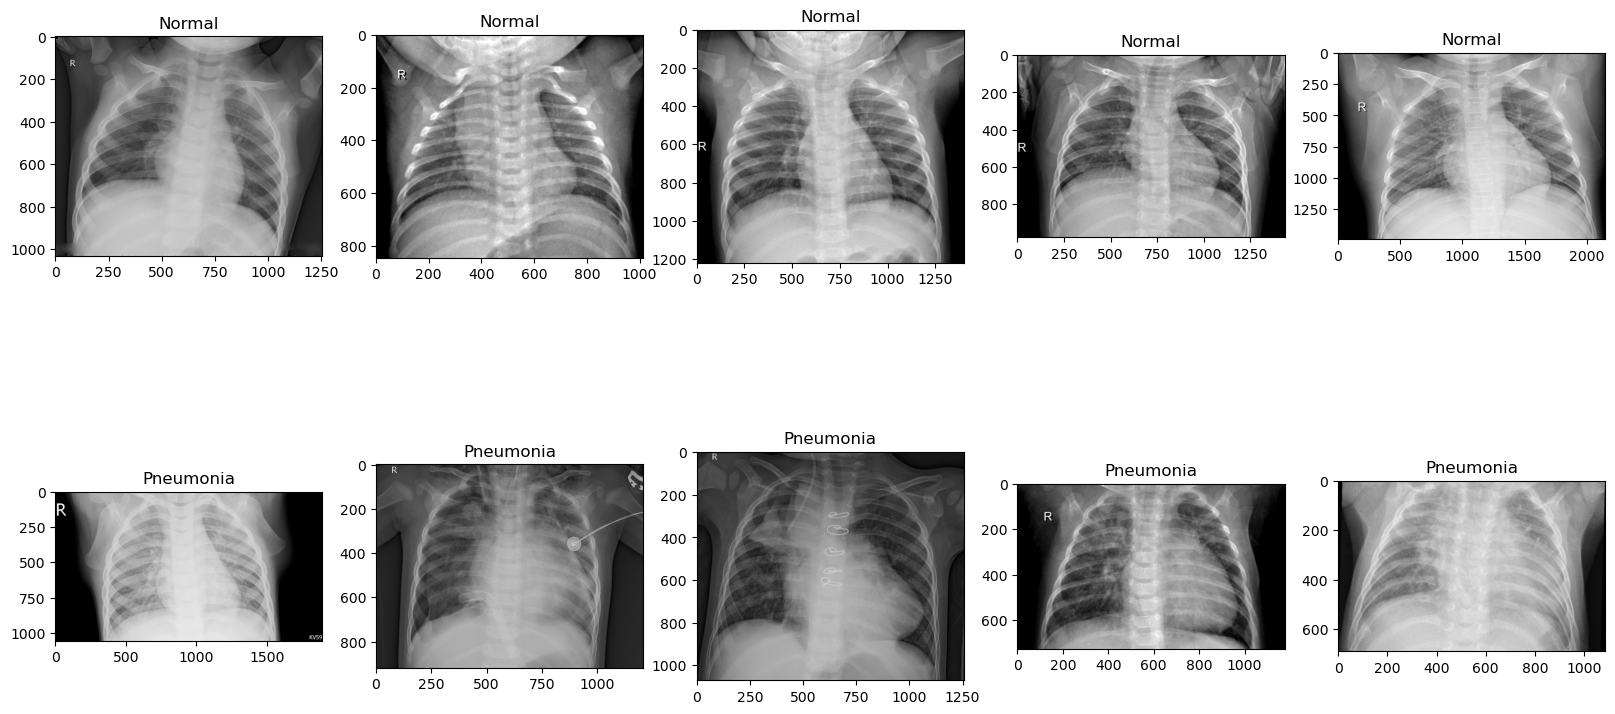

In [10]:
# Show 10 sample train images, 5 normal and 5 pneumonia
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
for img, ax in zip(train_normal[:5], axes[:5]):
    bgr_img = cv2.imread(img)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    ax.imshow(rgb_img)
    ax.set_title('Normal')
for img, ax in zip(train_pneumonia[:5], axes[5:]):
    bgr_img = cv2.imread(img)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    ax.imshow(rgb_img)
    ax.set_title('Pneumonia')

We see that the image size is not consistent, so maybe we should normalize to have a consistent size in our pytorch transform

### Create pytorch datasets
Note, some of this code is adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [2]:
import torch

# TODO(): Use baseline from bag of tricks

In [12]:
# Baseline training from bag of tricks paper
# 1. Randomly sample an image and decode it into 32-bit
# floating point raw pixel values in [0, 255].
# 2. Randomly crop a rectangular region whose aspect ratio
# is randomly sampled in [3/4, 4/3] and area randomly
# sampled in [8%, 100%], then resize the cropped region
# into a 224-by-224 square image.
# 3. Flip horizontally with 0.5 probability.
# 4. Scale hue, saturation, and brightness with coefficients
# uniformly drawn from [0.6, 1.4].
# 5. Add PCA noise with a coefficient sampled from a nor-
# mal distribution N (0, 0.1).

In [3]:
import dataset
import importlib
importlib.reload(dataset)

<module 'dataset' from '/home/nashir/Documents/UCF/spring2023/cap5516/assignment-1/dataset.py'>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloaders, dataset_sizes, class_names = dataset.load_xray_data()

In [5]:
class_names

['NORMAL', 'PNEUMONIA']

### Visualize images from the torch dataset with transforms

In [6]:
# Compute approximate mean and std of train dataset based on a single batch
images, _ = next(iter(dataloaders['train']))
# shape of images = [b,c,w,h]
mean, std = images.mean([0,2,3]), images.std([0,2,3])

In [7]:
mean, std

(tensor([0.5303, 0.5303, 0.5303]), tensor([0.1944, 0.1944, 0.1944]))

In [8]:
## Reload dataset with mean and std for transforms
dataloaders, dataset_sizes, class_names = dataset.load_xray_data(dataset.get_baseline_transforms(mean, std))

In [9]:
import viz

importlib.reload(viz)

<module 'viz' from '/home/nashir/Documents/UCF/spring2023/cap5516/assignment-1/viz.py'>

In [10]:
import torchvision

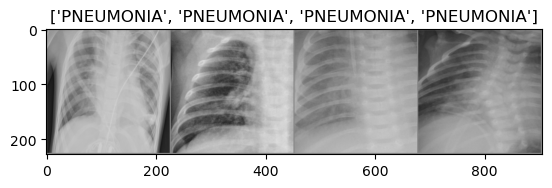

In [11]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

viz.imshow(out, mean, std, title=[class_names[x] for x in classes])


## Task 1.1
Train the model (e.g., ResNet-18) from scratch (i.e., random initialization of the model parameters) using the training X-ray images.

In [ ]:
import train

### Train a simple baseline model from scratch as first approach

In [13]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [14]:
n_outputs = 2

In [43]:
model_scratch = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

In [44]:
model_scratch, hist_scratch = train.train_model(
    model_scratch, criterion, optimizer_scratch, exp_lr_scheduler_scratch,
    dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------
Phase:  train
train loss: 0.5066; acc: 0.7656
Phase:  val
val loss: 0.3557; acc: 0.8290

Epoch 2/20
----------
Phase:  train
train loss: 0.4126; acc: 0.8177
Phase:  val
val loss: 0.3260; acc: 0.8558

Epoch 3/20
----------
Phase:  train
train loss: 0.3638; acc: 0.8442
Phase:  val
val loss: 0.3151; acc: 0.8672

Epoch 4/20
----------
Phase:  train
train loss: 0.3485; acc: 0.8492
Phase:  val
val loss: 0.3345; acc: 0.8520

Epoch 5/20
----------
Phase:  train
train loss: 0.3111; acc: 0.8714
Phase:  val
val loss: 0.2440; acc: 0.8968

Epoch 6/20
----------
Phase:  train
train loss: 0.3019; acc: 0.8753
Phase:  val
val loss: 0.2812; acc: 0.8777

Epoch 7/20
----------
Phase:  train
train loss: 0.2782; acc: 0.8879
Phase:  val
val loss: 0.2648; acc: 0.8873

Epoch 8/20
----------
Phase:  train
train loss: 0.2292; acc: 0.9066
Phase:  val
val loss: 0.2330; acc: 0.9102

Epoch 9/20
----------
Phase:  train
train loss: 0.2189; acc: 0.9145
Phase:  val
val loss: 0.2100; acc: 0.9083

E

### Save metrics

In [ ]:
train_loss_scratch, train_acc_scratch, val_loss_scratch, val_acc_scratch = hist_scratch
train.save_training_metrics("metrics/scratch_baseline", train_loss_scratch, train_acc_scratch, val_loss_scratch, val_acc_scratch)

### Save model

In [ ]:
# Save model
torch.save(model_scratch.state_dict(), 'models/scratch_baseline.pth')

### Analyze baseline scratch model performance

In [68]:
train_loss_scratch, train_acc_scratch, val_loss_scratch, val_acc_scratch = train.load_training_metrics("metrics/scratch_baseline.npz")

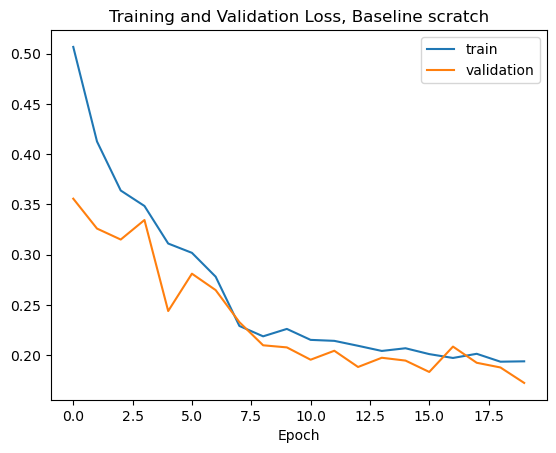

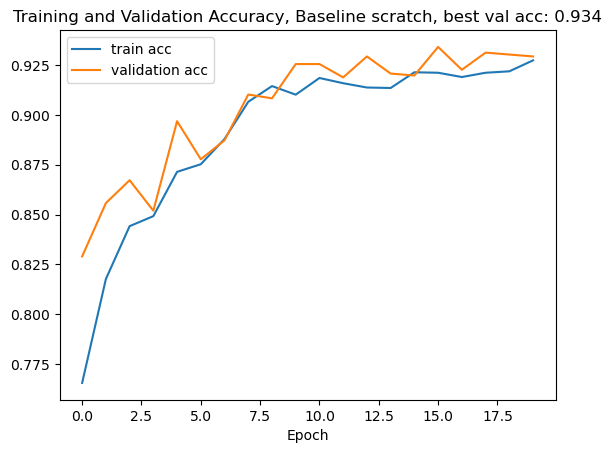

In [69]:
viz.plot_training_metrics(train_loss_scratch, train_acc_scratch, val_loss_scratch, val_acc_scratch, title="Baseline scratch")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

### Evaluate model on test set

In [63]:
# Load model
model_scratch = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_scratch.load_state_dict(torch.load('models/baseline_scratch.pth'))

<All keys matched successfully>

In [64]:
y_true_scratch, y_pred_scratch, test_accuracy_scratch, per_class_acc_scratch = train.evaluate_model_on_test_set(model_scratch, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 78.6 %
Accuracy for class: PNEUMONIA is 95.9 %
Overall accuracy (Test dataset (baseline scratch)): 89.4
Precision: 0.901
Recall: 0.873
F1 score: 0.883


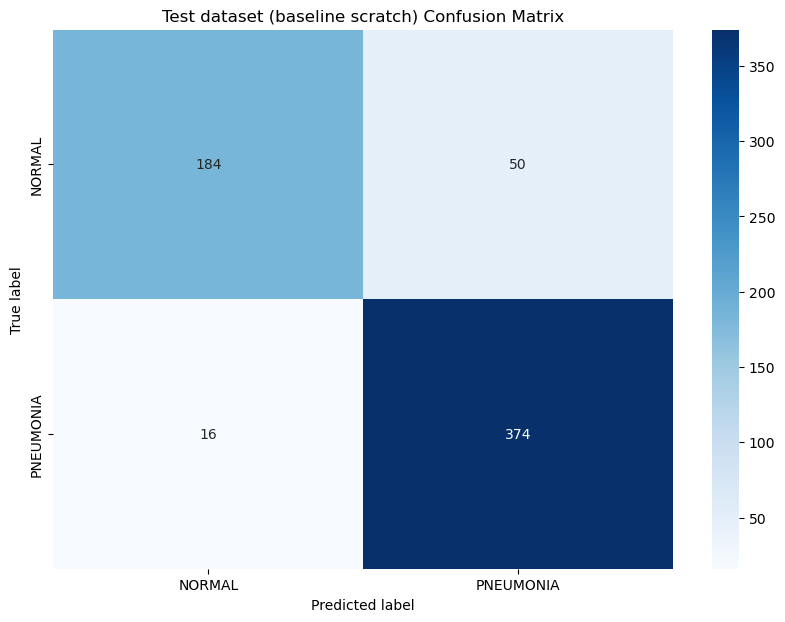

In [65]:
confusion_scratch, precision_scratch, recall_scratch, fscore_scratch, _ = train.compute_metrics_on_test_set(y_true_scratch, y_pred_scratch)
viz.show_test_summary_metrics(
    test_accuracy_scratch, per_class_acc_scratch, confusion_scratch, precision_scratch, recall_scratch, fscore_scratch,
    "Test dataset (baseline scratch)", class_names)

These results indicate data imbalance leading to less than ideal accuracy because the model over predicts pneumonia, since it sees more of these examples during training.

### Balance the data directly to address data imbalance

In [1]:
# dataloaders_b, dataset_sizes_b, class_names = dataset.load_oversampled_xray_data(dataset.get_baseline_transforms(mean, std))

NameError: name 'dataset' is not defined

### Use weighted loss function to address data imbalance

In [16]:
labels = dataset.get_labels(dataloaders['train'])

In [21]:
class_weights = dataset.compute_class_weights(labels).to(device)
class_weights

tensor([0.7474, 0.2526], device='cuda:0')

We see that the weight for normal is higher because there are fewer instances of the normal class in the dataset.

In [22]:
model_scratch_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_weighted.fc.in_features
model_scratch_weighted.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)
# Observe that all parameters are being optimized
optimizer_scratch_weighted = optim.SGD(model_scratch_weighted.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_scratch_weighted = lr_scheduler.StepLR(optimizer_scratch_weighted, step_size=7, gamma=0.1)

In [23]:
model_scratch_weighted, hist_scratch_weighted = train.train_model(
    model_scratch_weighted, criterion_weighted, optimizer_scratch_weighted,
    exp_lr_scheduler_scratch_weighted, dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------
Phase:  train
train loss: 0.6274; acc: 0.7467
Phase:  val
val loss: 0.5498; acc: 0.7937

Epoch 2/20
----------
Phase:  train
train loss: 0.5453; acc: 0.7766
Phase:  val
val loss: 0.3451; acc: 0.8701

Epoch 3/20
----------
Phase:  train
train loss: 0.4354; acc: 0.8277
Phase:  val
val loss: 0.3034; acc: 0.8854

Epoch 4/20
----------
Phase:  train
train loss: 0.4311; acc: 0.8318
Phase:  val
val loss: 0.3001; acc: 0.8749

Epoch 5/20
----------
Phase:  train
train loss: 0.3854; acc: 0.8447
Phase:  val
val loss: 0.3211; acc: 0.8777

Epoch 6/20
----------
Phase:  train
train loss: 0.3578; acc: 0.8652
Phase:  val
val loss: 0.2699; acc: 0.9093

Epoch 7/20
----------
Phase:  train
train loss: 0.3361; acc: 0.8655
Phase:  val
val loss: 0.3781; acc: 0.8873

Epoch 8/20
----------
Phase:  train
train loss: 0.2717; acc: 0.8965
Phase:  val
val loss: 0.2389; acc: 0.9102

Epoch 9/20
----------
Phase:  train
train loss: 0.2647; acc: 0.8987
Phase:  val
val loss: 0.2373; acc: 0.9198

E

In [24]:
train_loss_scratch_weighted, train_acc_scratch_weighted, val_loss_scratch_weighted, val_acc_scratch_weighted = hist_scratch_weighted
train.save_training_metrics("metrics/scratch_weighted", train_loss_scratch_weighted, train_acc_scratch_weighted, val_loss_scratch_weighted, val_acc_scratch_weighted)

### Analyze baseline model performance

In [66]:
train_loss_scratch_weighted, train_acc_scratch_weighted, val_loss_scratch_weighted, val_acc_scratch_weighted = train.load_training_metrics("metrics/scratch_weighted.npz")

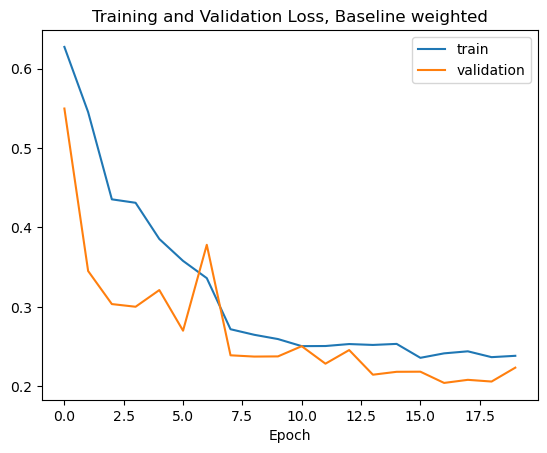

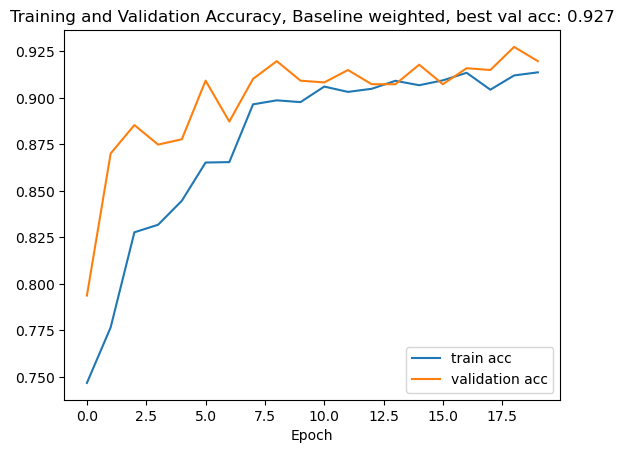

In [67]:
viz.plot_training_metrics(train_loss_scratch_weighted, train_acc_scratch_weighted, val_loss_scratch_weighted, val_acc_scratch_weighted, title="Baseline weighted")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

### Save model

In [26]:
# Save model
torch.save(model_scratch_weighted.state_dict(), 'models/scratch_weighted.pth')

### Load model

In [27]:
# Load model
model_scratch_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_weighted.fc.in_features
model_scratch_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_scratch_weighted.load_state_dict(torch.load('models/scratch_weighted.pth'))

<All keys matched successfully>

### Evaluate model on test set

In [70]:
y_true_scratch_weighted, y_pred_scratch_weighted, test_accuracy_scratch_weighted, per_class_acc_scratch_weighted = train.evaluate_model_on_test_set(model_scratch_weighted, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 76.9 %
Accuracy for class: PNEUMONIA is 97.9 %
Overall accuracy (Test dataset (scratch weighted)): 90.1
Precision: 0.917
Recall: 0.874
F1 score: 0.889


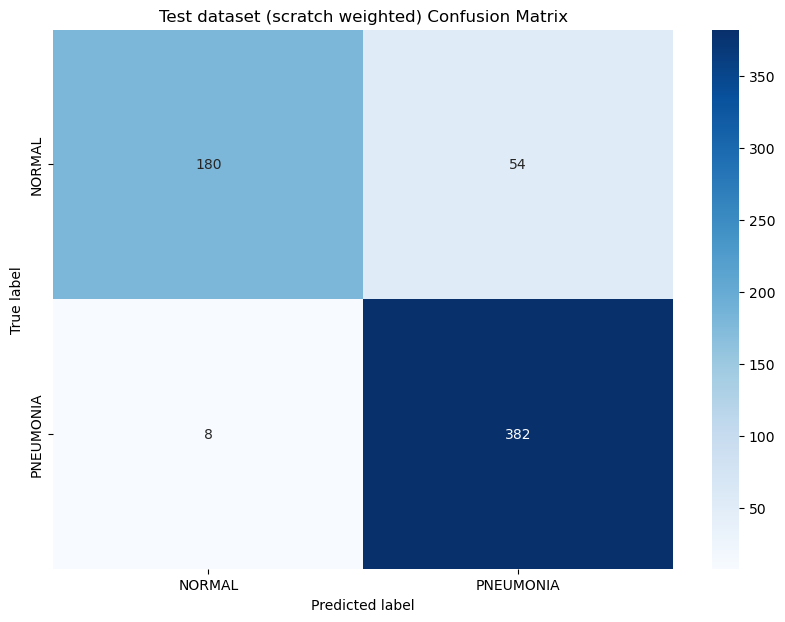

In [71]:
confusion_scratch_weighted, precision_scratch_weighted, recall_scratch_weighted, fscore_scratch_weighted, _ = train.compute_metrics_on_test_set(y_true_scratch_weighted, y_pred_scratch_weighted)
viz.show_test_summary_metrics(
    test_accuracy_scratch_weighted, per_class_acc_scratch_weighted, confusion_scratch_weighted, precision_scratch_weighted, recall_scratch_weighted, fscore_scratch_weighted,
    "Test dataset (scratch weighted)", class_names)

### Train from scratch with cutmix

In [76]:
model_scratch_cutmix = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_cutmix.fc.in_features
model_scratch_cutmix.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_scratch_cutmix = optim.SGD(model_scratch_cutmix.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_scratch_cutmix = lr_scheduler.StepLR(optimizer_scratch_cutmix, step_size=7, gamma=0.1)

In [79]:
model_scratch_cutmix, hist_scratch_cutmix = train.train_model(
    model_scratch_cutmix, criterion, optimizer_scratch_cutmix, exp_lr_scheduler_scratch_cutmix,
    dataloaders, dataset_sizes, num_epochs=20, use_cutmix=True)

Epoch 1/20
----------
Phase:  train
train loss: 0.5456; acc: 0.7584
Phase:  val
val loss: 0.3225; acc: 0.8510

Epoch 2/20
----------
Phase:  train
train loss: 0.4992; acc: 0.7790
Phase:  val
val loss: 0.3756; acc: 0.8357

Epoch 3/20
----------
Phase:  train
train loss: 0.4526; acc: 0.8033
Phase:  val
val loss: 0.3341; acc: 0.8453

Epoch 4/20
----------
Phase:  train
train loss: 0.4304; acc: 0.8136
Phase:  val
val loss: 0.2877; acc: 0.8730

Epoch 5/20
----------
Phase:  train
train loss: 0.4156; acc: 0.8182
Phase:  val
val loss: 0.2538; acc: 0.8997

Epoch 6/20
----------
Phase:  train
train loss: 0.3947; acc: 0.8284
Phase:  val
val loss: 0.2548; acc: 0.8959

Epoch 7/20
----------
Phase:  train
train loss: 0.3647; acc: 0.8495
Phase:  val
val loss: 0.2460; acc: 0.8921

Epoch 8/20
----------
Phase:  train
train loss: 0.3080; acc: 0.8714
Phase:  val
val loss: 0.2220; acc: 0.9054

Epoch 9/20
----------
Phase:  train
train loss: 0.3157; acc: 0.8645
Phase:  val
val loss: 0.2323; acc: 0.9045

E

### Save metrics

In [80]:
train_loss_scratch_cutmix, train_acc_scratch_cutmix, val_loss_scratch_cutmix, val_acc_scratch_cutmix = hist_scratch_cutmix
train.save_training_metrics("metrics/scratch_cutmix", train_loss_scratch_cutmix, train_acc_scratch_cutmix, val_loss_scratch_cutmix, val_acc_scratch_cutmix)

### Save model

In [81]:
# Save model
torch.save(model_scratch.state_dict(), 'models/scratch_cutmix.pth')

### Analyze scratch cutmix model performance

In [83]:
train_loss_scratch_cutmix, train_acc_scratch_cutmix, val_loss_scratch_cutmix, val_acc_scratch_cutmix = train.load_training_metrics("metrics/scratch_cutmix.npz")

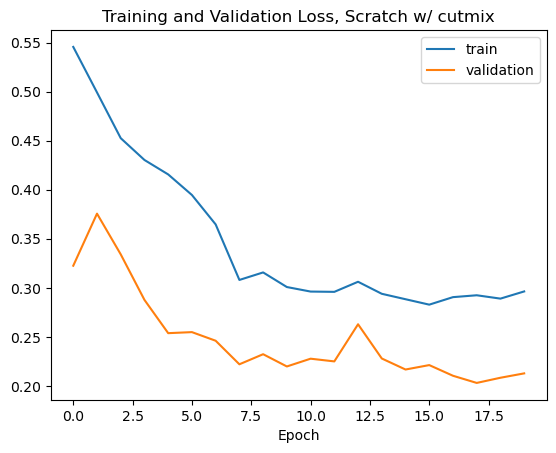

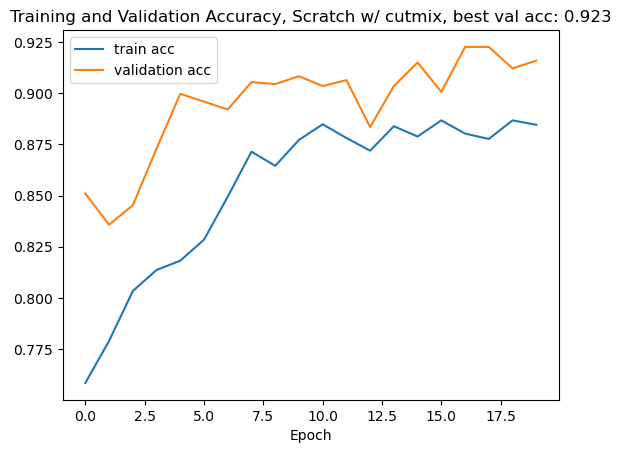

In [84]:
viz.plot_training_metrics(train_loss_scratch_cutmix, train_acc_scratch_cutmix, val_loss_scratch_cutmix, val_acc_scratch_cutmix, title="Scratch w/ cutmix")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

### Evaluate model on test set

In [86]:
# Load model
model_scratch_cutmix = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch_cutmix.fc.in_features
model_scratch_cutmix.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_scratch_cutmix.load_state_dict(torch.load('models/scratch_cutmix.pth'))

<All keys matched successfully>

In [87]:
y_true_scratch_cutmix, y_pred_scratch_cutmix, test_accuracy_scratch_cutmix, per_class_acc_scratch_cutmix = train.evaluate_model_on_test_set(model_scratch_cutmix, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 81.2 %
Accuracy for class: PNEUMONIA is 97.4 %
Overall accuracy (Test dataset (scratch cutmix)): 91.3
Precision: 0.923
Recall: 0.893
F1 score: 0.905


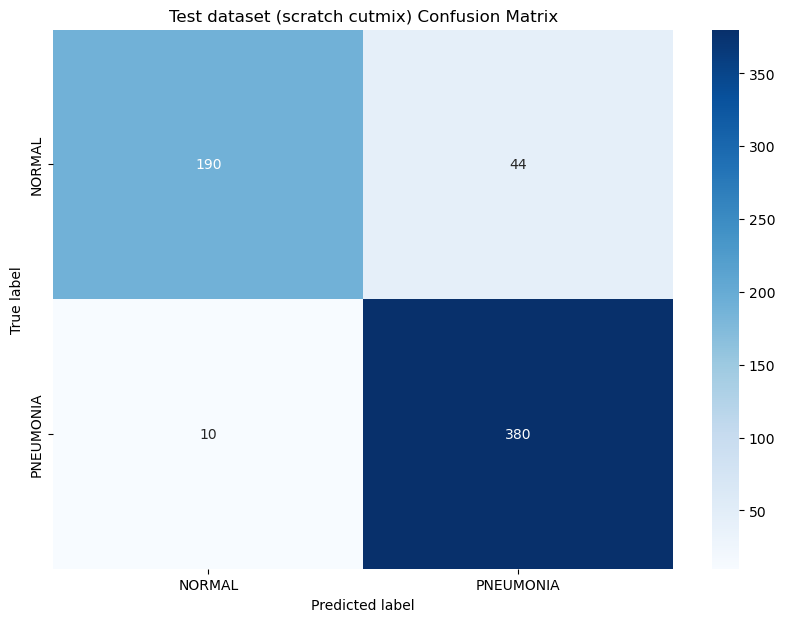

In [88]:
confusion_scratch_cutmix, precision_scratch_cutmix, recall_scratch_cutmix, fscore_scratch_cutmix, _ = train.compute_metrics_on_test_set(y_true_scratch_cutmix, y_pred_scratch_cutmix)
viz.show_test_summary_metrics(
    test_accuracy_scratch_cutmix, per_class_acc_scratch_cutmix, confusion_scratch_cutmix, precision_scratch_cutmix, recall_scratch_cutmix, fscore_scratch_cutmix,
    "Test dataset (scratch cutmix)", class_names)

## Task 1.2
Leverage the pre-trained ResNet-18 (the same CNN used in Task 1.1) model on the ImageNet and fine tune the model on the target X-ray images (training set).

### First try training throughout the whole network since we have a lot of data, and the target domain (xray images) is different from the original domain (natural images)

In [32]:
model_ft = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
model_ft, hist_ft = train.train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler_ft,
    dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------
Phase:  train
train loss: 0.4105; acc: 0.8397
Phase:  val
val loss: 0.2199; acc: 0.9140

Epoch 2/20
----------
Phase:  train
train loss: 0.2906; acc: 0.8879
Phase:  val
val loss: 0.2837; acc: 0.9064

Epoch 3/20
----------
Phase:  train
train loss: 0.3014; acc: 0.8908
Phase:  val
val loss: 0.1603; acc: 0.9494

Epoch 4/20
----------
Phase:  train
train loss: 0.2391; acc: 0.9104
Phase:  val
val loss: 0.1457; acc: 0.9456

Epoch 5/20
----------
Phase:  train
train loss: 0.2085; acc: 0.9250
Phase:  val
val loss: 0.1782; acc: 0.9398

Epoch 6/20
----------
Phase:  train
train loss: 0.2457; acc: 0.9137
Phase:  val
val loss: 0.1379; acc: 0.9456

Epoch 7/20
----------
Phase:  train
train loss: 0.1895; acc: 0.9345
Phase:  val
val loss: 0.1499; acc: 0.9465

Epoch 8/20
----------
Phase:  train
train loss: 0.1568; acc: 0.9496
Phase:  val
val loss: 0.1218; acc: 0.9522

Epoch 9/20
----------
Phase:  train
train loss: 0.1356; acc: 0.9551
Phase:  val
val loss: 0.1351; acc: 0.9513

E

In [41]:
train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft = hist_ft
train.save_training_metrics("metrics/ft_baseline", train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft)

### Analyze baseline fine tuned model performance

In [72]:
train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft = train.load_training_metrics("metrics/ft_baseline.npz")

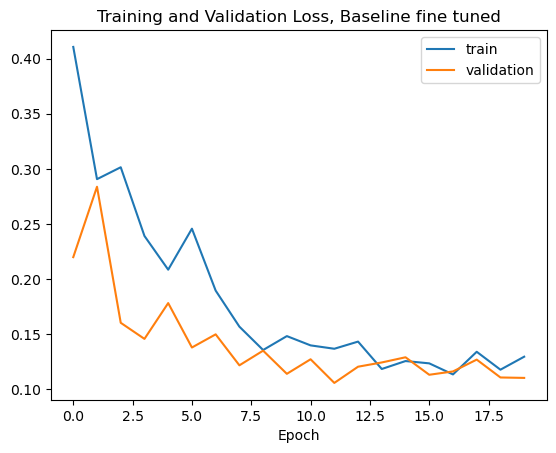

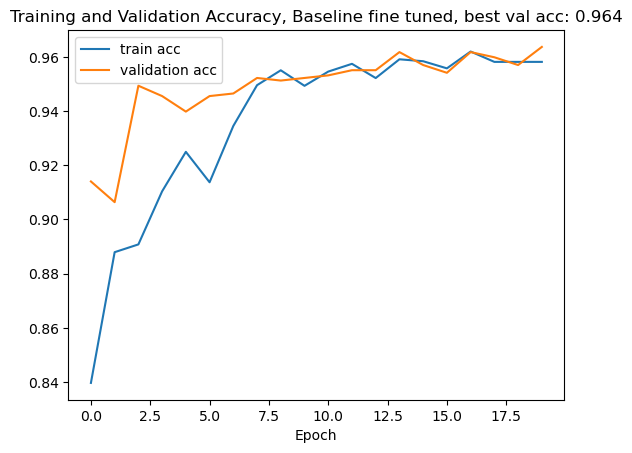

In [73]:
viz.plot_training_metrics(train_loss_ft, train_acc_ft, val_loss_ft, val_acc_ft, title="Baseline fine tuned")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

### Save model

In [37]:
# Save model
torch.save(model_ft.state_dict(), 'models/ft_baseline.pth')

### Load model

In [38]:
# Load model
model_ft = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_ft.load_state_dict(torch.load('models/ft_baseline.pth'))

<All keys matched successfully>

### Evaluate model on test set

In [83]:
y_true_ft, y_pred_ft, test_accuracy_ft, per_class_acc_ft = train.evaluate_model_on_test_set(model_ft, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 79.1 %
Accuracy for class: PNEUMONIA is 99.5 %
Overall accuracy (Test dataset (baseline fine tune)): 91.8
Precision: 0.939
Recall: 0.893
F1 score: 0.909


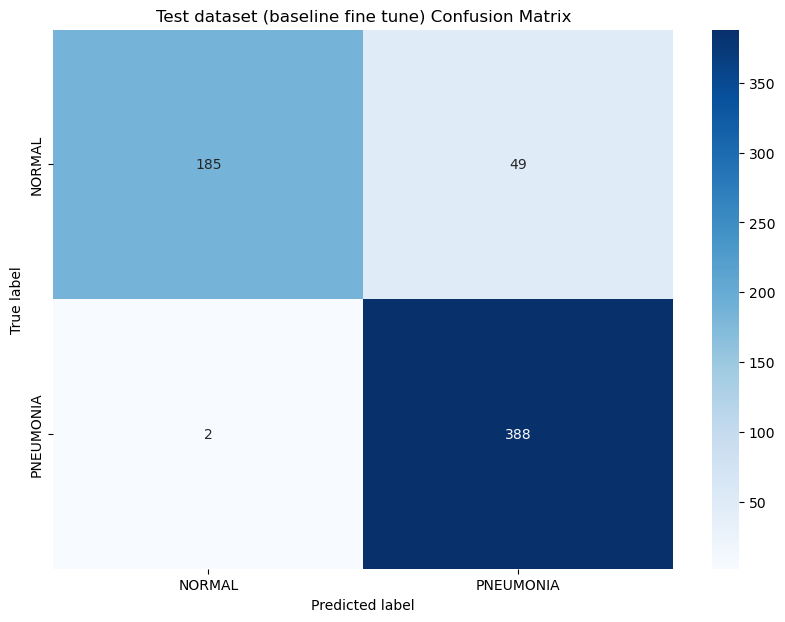

In [84]:
confusion_ft, precision_ft, recall_ft, fscore_ft, _ = train.compute_metrics_on_test_set(y_true_ft, y_pred_ft)
viz.show_test_summary_metrics(test_accuracy_ft, per_class_acc_ft, confusion_ft, precision_ft, recall_ft, fscore_ft, "Test dataset (baseline fine tune)", class_names)

This model seems to be even more affected by the data imbalance; the model predicts even more instances of pneumonia than the baseline model without transfer learning.

### Use weighted loss function to address data imbalance

In [33]:
class_weights

tensor([0.7474, 0.2526], device='cuda:0')

In [34]:
model_ft_weighted = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_weighted.fc.in_features
model_ft_weighted.fc = nn.Linear(num_ftrs, n_outputs)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights)
# Observe that all parameters are being optimized
optimizer_ft_weighted = optim.SGD(model_ft_weighted.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft_weighted = lr_scheduler.StepLR(optimizer_ft_weighted, step_size=7, gamma=0.1)

In [36]:
model_ft_weighted, hist_ft_weighted = train.train_model(
    model_ft_weighted, criterion_weighted, optimizer_ft_weighted,
    exp_lr_scheduler_ft_weighted, dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------
Phase:  train
train loss: 0.4926; acc: 0.8153
Phase:  val
val loss: 0.3120; acc: 0.9179

Epoch 2/20
----------
Phase:  train
train loss: 0.3880; acc: 0.8593
Phase:  val
val loss: 0.2405; acc: 0.8968

Epoch 3/20
----------
Phase:  train
train loss: 0.3425; acc: 0.8824
Phase:  val
val loss: 0.2208; acc: 0.8873

Epoch 4/20
----------
Phase:  train
train loss: 0.3115; acc: 0.8930
Phase:  val
val loss: 0.2177; acc: 0.9179

Epoch 5/20
----------
Phase:  train
train loss: 0.2742; acc: 0.9140
Phase:  val
val loss: 0.1387; acc: 0.9427

Epoch 6/20
----------
Phase:  train
train loss: 0.2581; acc: 0.9157
Phase:  val
val loss: 0.1547; acc: 0.9427

Epoch 7/20
----------
Phase:  train
train loss: 0.2383; acc: 0.9302
Phase:  val
val loss: 0.1933; acc: 0.9303

Epoch 8/20
----------
Phase:  train
train loss: 0.1765; acc: 0.9412
Phase:  val
val loss: 0.1402; acc: 0.9484

Epoch 9/20
----------
Phase:  train
train loss: 0.1745; acc: 0.9450
Phase:  val
val loss: 0.1274; acc: 0.9503

E

In [ ]:
train_loss_ft_weighted, train_acc_ft_weighted, val_loss_ft_weighted, val_acc_ft_weighted = hist_ft_weighted
train.save_training_metrics("metrics/ft_weighted", train_loss_ft_weighted, train_acc_ft_weighted, val_loss_ft_weighted, val_acc_ft_weighted)

### Analyze baseline model performance

In [74]:
train_loss_ft_weighted, train_acc_ft_weighted, val_loss_ft_weighted, val_acc_ft_weighted = train.load_training_metrics("metrics/ft_weighted.npz")

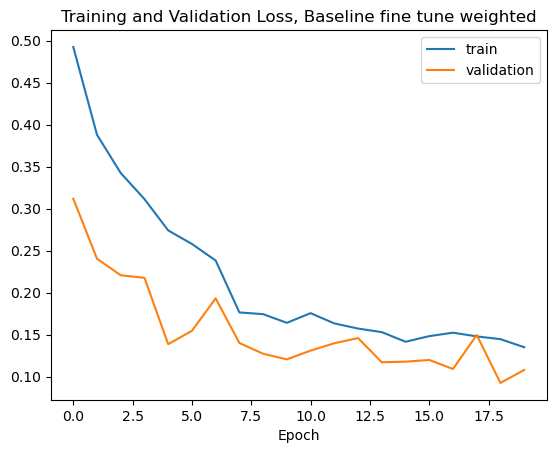

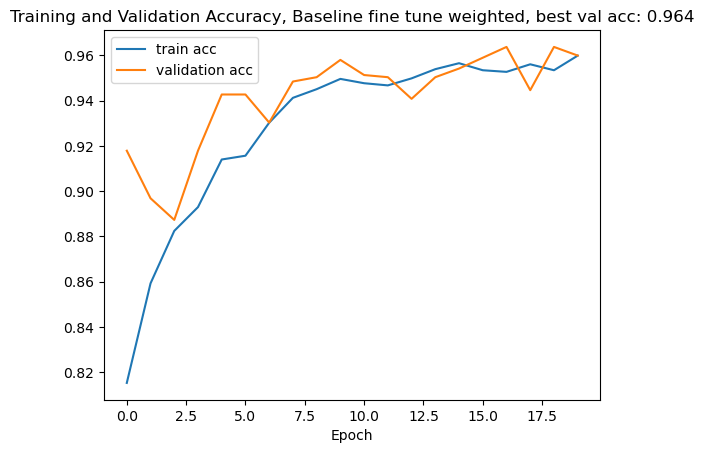

In [75]:
viz.plot_training_metrics(train_loss_ft_weighted, train_acc_ft_weighted, val_loss_ft_weighted, val_acc_ft_weighted, title="Baseline fine tune weighted")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

### Save model

In [49]:
# Save model
torch.save(model_ft_weighted.state_dict(), 'models/ft_weighted.pth')

### Load model

In [50]:
# Load model
model_ft_weighted = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_weighted.fc.in_features
model_ft_weighted.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_ft_weighted.load_state_dict(torch.load('models/ft_weighted.pth'))

<All keys matched successfully>

### Evaluate model on test set

In [53]:
y_true_ft_weighted, y_pred_ft_weighted, test_accuracy_ft_weighted, per_class_acc_ft_weighted = train.evaluate_model_on_test_set(model_ft_weighted, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 80.8 %
Accuracy for class: PNEUMONIA is 99.5 %
Overall accuracy (Test dataset (baseline fine tuned weighted)): 92.5
Precision: 0.943
Recall: 0.901
F1 score: 0.916


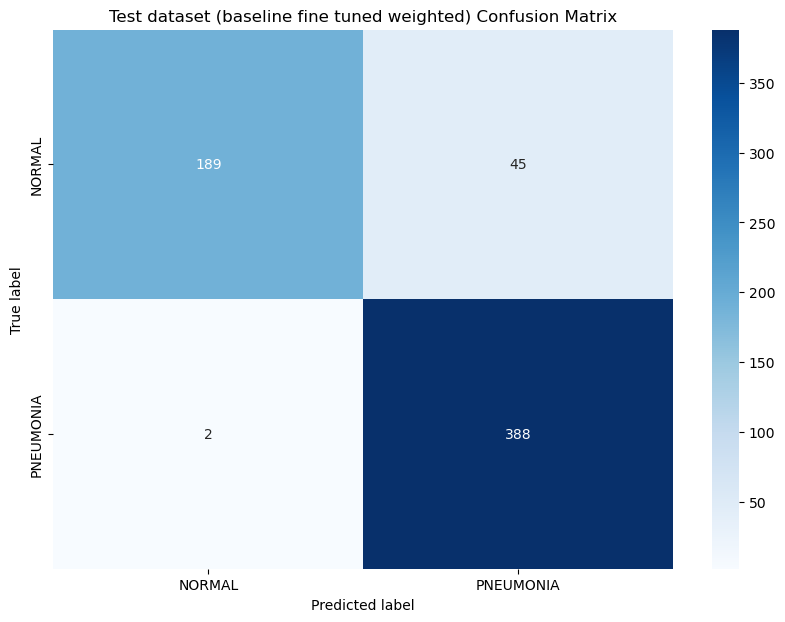

In [54]:
confusion_ft_weighted, precision_ft_weighted, recall_ft_weighted, fscore_ft_weighted, _ = train.compute_metrics_on_test_set(y_true_ft_weighted, y_pred_ft_weighted)
viz.show_test_summary_metrics(
    test_accuracy_ft_weighted, per_class_acc_ft_weighted, confusion_ft_weighted, precision_ft_weighted, recall_ft_weighted, fscore_ft_weighted,
    "Test dataset (fine tuned weighted)", class_names)

### Train pretrained model with cutmix

In [89]:
model_ft_cutmix = resnet18(weights=ResNet18_Weights.DEFAULT)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_cutmix.fc.in_features
model_ft_cutmix.fc = nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft_cutmix = optim.SGD(model_ft_cutmix.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft_cutmix = lr_scheduler.StepLR(optimizer_ft_cutmix, step_size=7, gamma=0.1)

In [90]:
model_ft_cutmix, hist_ft_cutmix = train.train_model(
    model_ft_cutmix, criterion, optimizer_ft_cutmix, exp_lr_scheduler_ft_cutmix,
    dataloaders, dataset_sizes, num_epochs=20, use_cutmix=True)

Epoch 1/20
----------
Phase:  train
train loss: 0.4821; acc: 0.8093
Phase:  val
val loss: 0.2011; acc: 0.9093

Epoch 2/20
----------
Phase:  train


### Save metrics

In [ ]:
train_loss_ft_cutmix, train_acc_ft_cutmix, val_loss_ft_cutmix, val_acc_ft_cutmix = hist_ft_cutmix
train.save_training_metrics("metrics/ft_cutmix", train_loss_ft_cutmix, train_acc_ft_cutmix, val_loss_ft_cutmix, val_acc_ft_cutmix)

### Save model

In [ ]:
# Save model
torch.save(model_ft.state_dict(), 'models/ft_cutmix.pth')

### Analyze scratch cutmix model performance

In [ ]:
train_loss_ft_cutmix, train_acc_ft_cutmix, val_loss_ft_cutmix, val_acc_ft_cutmix = train.load_training_metrics("metrics/ft_cutmix.npz")

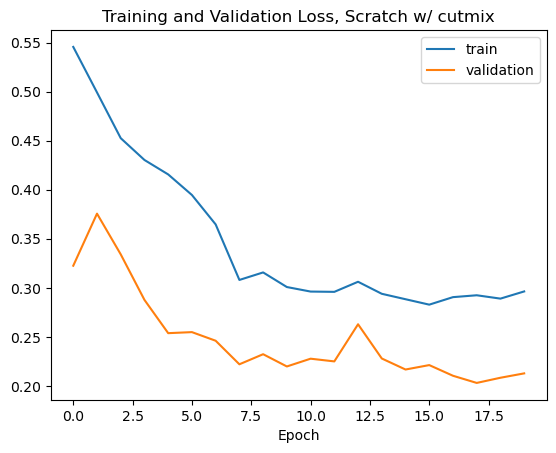

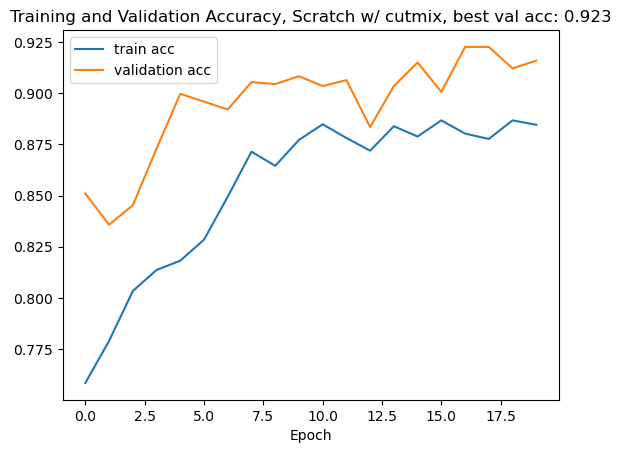

In [ ]:
viz.plot_training_metrics(train_loss_ft_cutmix, train_acc_ft_cutmix, val_loss_ft_cutmix, val_acc_ft_cutmix, title="Fine tune w/ cutmix")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

### Evaluate model on test set

In [ ]:
# Load model
model_ft_cutmix = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_ft_cutmix.fc.in_features
model_ft_cutmix.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_ft_cutmix.load_state_dict(torch.load('models/ft_cutmix.pth'))

<All keys matched successfully>

In [ ]:
y_true_ft_cutmix, y_pred_ft_cutmix, test_accuracy_ft_cutmix, per_class_acc_ft_cutmix = train.evaluate_model_on_test_set(model_ft_cutmix, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 81.2 %
Accuracy for class: PNEUMONIA is 97.4 %
Overall accuracy (Test dataset (scratch cutmix)): 91.3
Precision: 0.923
Recall: 0.893
F1 score: 0.905


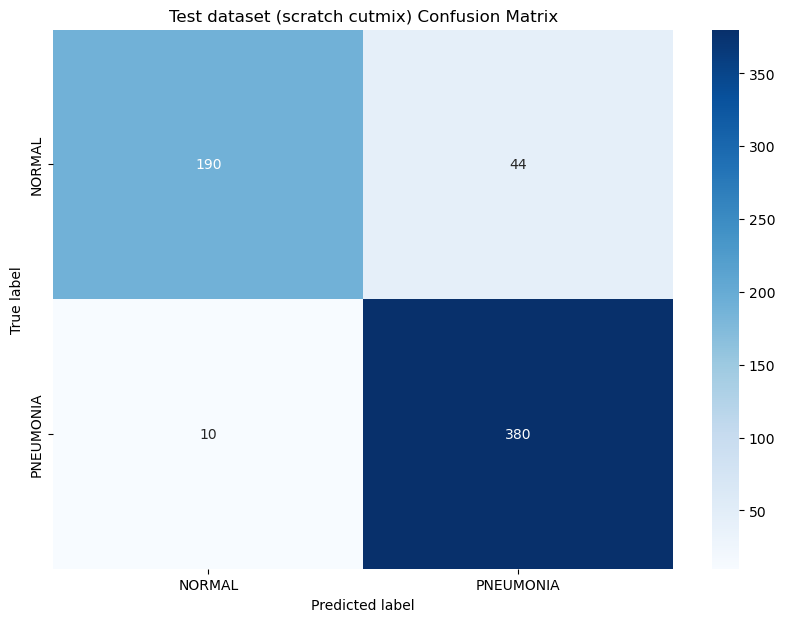

In [ ]:
confusion_ft_cutmix, precision_ft_cutmix, recall_ft_cutmix, fscore_ft_cutmix, _ = train.compute_metrics_on_test_set(y_true_ft_cutmix, y_pred_ft_cutmix)
viz.show_test_summary_metrics(
    test_accuracy_ft_cutmix, per_class_acc_ft_cutmix, confusion_ft_cutmix, precision_ft_cutmix, recall_ft_cutmix, fscore_ft_cutmix,
    "Test dataset (ft cutmix)", class_names)

# Analysis

### Gradcam

### Filter visualization

### Nearest Neighbors on last layer

### Dimensionality reduction on samples from last layer visualized with PCA and t-SNE